In [1]:
import pickle as p
import numpy as np
import tensorflow as tf
import random
import lab1_utils as utils
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Intro to TensorFlow

## What is a Computation Graph?

Everything in TensorFlow comes down to building a computation graph. What is a computation graph? Its just a series of math operations that occur in some order. Here is an example of a simple computation graph:

<img src="files/computation-graph.png">

This graph takes 2 inputs, (a, b) and computes an output (e). Each node in the graph is an operation that takes some input, does some computation, and passes its output to another node.

We could make this computation graph in TensorFlow in the following way:

In [2]:
a = tf.placeholder(tf.float32)
b = tf.placeholder(tf.float32)
c = tf.add(a, b)
d = tf.sub(b, 1)
e = tf.mul(c, d)

Tensorflow uses tf.placeholder to handle inputs to the model. This is like making a reservation at a restaurant. The restaurant reserves a spot for 5 people, but you are free to fill those seats with any set of friends you want to. tf.placeholder lets you specify that some input will be coming in, of some shape and some type. Only when you run the computation graph do you actually provide the values of this input data. You would run this simple computation graph like this:

In [3]:
with tf.Session() as session:
    a_data, b_data = 3.0, 6.0
    feed_dict = {a: a_data, b: b_data}
    output = session.run([e], feed_dict=feed_dict)
    print(output) # 45.0

[45.0]


We use feed_dict to pass in the actual input data into the graph. We use session.run to get the output from the c operation in the graph. Since e is at the end of the graph, this ends up running the entire graph and returning the number 45 - cool!

## Neural Networks in Tensorflow

We can define neural networks in TensorFlow using computation graphs. Here is an example, very simple neural network (just 1 perceptron):

<img src="files/computation-graph-2.png">

This graph takes an input, (x) and computes an output (out). It does it with what we learned in class, `out = sigmoid(W*x+b)`.

We could make this computation graph in TensorFlow in the following way:

In [4]:
n_input_nodes = 2
n_output_nodes = 1
x = tf.placeholder(tf.float32, (None, n_input_nodes))
W = tf.Variable(tf.ones((n_input_nodes, n_output_nodes)), dtype=tf.float32)
b = tf.Variable(tf.zeros(n_output_nodes), dtype=tf.float32)

'''TODO: Define the operation for z (use tf.matmul to multiply W and x).'''
z = tf.matmul(x, W) + b

'''TODO: Define the operation for out (use tf.sigmoid).'''
out = tf.sigmoid(z)

To run this graph, we again use session.run() and feed in our input via feed_dict.

In [5]:
test_input = [[0.5, 0.5]]
with tf.Session() as session:
    tf.global_variables_initializer().run(session=session)
    feed_dict = {x: test_input}
    output = session.run([out], feed_dict=feed_dict)
    print(output[0]) # This should output 0.73105. If not, double-check your code above

[[ 0.7310586]]


We can also set the value of a tf.Variable when we make it. Below is an example where we set the value of tf.Variable ourselves. We've made a classification dataset for you to play around with, and see how the decision boundary changes with the model parameters (weights and bias). Try to get all the datapoints correct (green)!

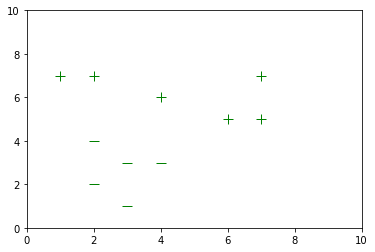

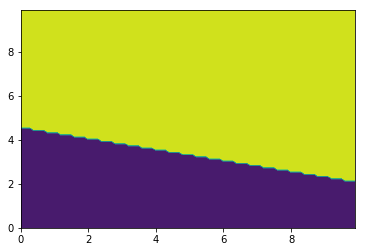

predictions [array([[ 0.58661759]], dtype=float32), array([[ 0.57932425]], dtype=float32), array([[ 0.41580945]], dtype=float32), array([[ 0.4750208]], dtype=float32), array([[ 0.48250711]], dtype=float32), array([[ 0.57199615]], dtype=float32), array([[ 0.55724788]], dtype=float32), array([[ 0.62245935]], dtype=float32), array([[ 0.56463629]], dtype=float32), array([[ 0.4975]], dtype=float32), array([[ 0.4378235]], dtype=float32)]


In [6]:
'''TODO: manually optimize weight_values and bias_value to classify points'''

# Modify weight_values, bias_value in the above code to adjust the decision boundary
# See if you can classify all the points correctly (all markers green)

weight_values = np.array([[0.03], [0.12]]) # TODO change values and re-run
bias_value = np.array([[-0.55]]) #TODO change values and re-run

# A pretty good boundary is made with:
# weight_values = np.array([[0.03], [0.12]])
# bias_value = np.array([[-0.5]])

x = tf.placeholder(tf.float32, (None, 2), name='x')
W = tf.Variable(weight_values, name='W', dtype=tf.float32)
b = tf.Variable(bias_value, name='b', dtype=tf.float32)
z = tf.matmul(x, W) + b
out = tf.sigmoid(z)

data = np.array([[2, 7], [1, 7], [3, 1], [3, 3], [4, 3], [4, 6], [6, 5], [7, 7], [7, 5], [2, 4], [2, 2]])
y = np.array([1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0])
with tf.Session() as session:
    tf.global_variables_initializer().run(session=session)
    utils.classify_and_plot(data, y, x, out, session)

## Tweet Sentiment Analysis

Let's move to a real-world task. We're going to be classifying tweets as positive, negative, or neutral. Check out the very negative tweet below:

<img src="files/tweet-model.jpg" style="width: 500px;">


## Building the Model

### Building an MLP

MLP or Multi-layer perceptron is a basic archetecture where where we multiply our representation with some matrix `W` and add some bias `b` and then apply some nonlineanity like `tanh` at each layer. Layers are fully connected to the next. As the network gets deeper, it's expressive power grows exponentially and so they can draw some pretty fancy decision boundaries. In this exercise, you'll build your own MLP, with 2 hidden layers (layers that aren't input or output).

To make training more stable and efficient, we'll actually evaluate 128 tweets at a time, and take gradients with respect to the loss on the 128. We call this idea **training with mini-batches**.

### Step 1: Representing Words

In this model, we’ll be representing tweets as [bag-of-words](https://en.wikipedia.org/wiki/Bag-of-words_model) (BOW) representations. BOW representations are vectors where each element index represents a different word and its value represents the number of times this word appears in our sentence. This means that each sentence will be represented by a vector that is vocab_size long. Our output labels will be represented as a vector of size n_classes (3). We get this data with some utility functions:

In [7]:
# load data
X, y, index_to_word, sentences = utils.load_sentiment_data_bow()
X_train, y_train, X_test, y_test = utils.split_data(X, y)
vocab_size = X.shape[1]
n_classes = y.shape[1]

print("Tweet:", sentences[5])
print("Label:", y[5])
print("Bag of Words Representation:", X_train[5])

Tweet: @VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.
it's really the only bad thing about flying VA
Label: [ 0.  0.  1.]
Bag of Words Representation: [ 0.  0.  0. ...,  0.  0.  0.]


### Step 2: Making Placeholders

So we have our data loaded as numpy arrays. But remember, TensorFlow graphs begin with generic placeholder inputs, not actual data. We feed the actual data in later once the full graph has been defined. We define our placeholders like this:

In [8]:
data_placeholder = tf.placeholder(tf.float32, shape=(None, vocab_size), name='data_placeholder')

'''TODO: Make the labels placeholder.''';
labels_placeholder = tf.placeholder(tf.float32, shape=(None, n_classes), name='labels_placeholder')

#### Why Do We Pass in None?

A note about ‘None’ and fluid-sized dimensions:

You may notice that the first dimension of shape of data_placeholder is ‘None’. data_placeholder should have shape (num_tweets, vocab_size). However, we don’t know how many tweets we are going to be passing in at a time, num_tweets is unknown. Its possible that we only want to pass in 1 tweet at a time, or 30, or 1,000. Thankfully, TensorFlow allows us to specify placeholders with fluid-sized dimensions. We can use None to specify some fluid dimension of our shape. When our data eventually gets passed in as a numpy array, TensorFlow can figure out what the value of the fluid-size dimension should be.

### Step 3: Define Network Parameters
Let’s now define and initialize our network parameters.

We'll our model parameters using tf.Variable. When you create a tf.Variable you pass a Tensor as its initial value to the Variable() constructor. A Tensor is a term for any N-dimensional matrix. There are a ton of different initial Tensor value functions you can use ([full list](https://www.tensorflow.org/api_docs/python/constant_op/)). All these functions take a list argument that determines their shape. Here we use tf.truncated_normal for our weights, and tf.zeros for our biases. Its important that the shape of these parameters are compatible. We’ll be matrix-multiplying the weights, so the last dimension of the previous weight matrix must equal the first dimension of the next weight matrix. Notice this pattern in the following tensor initialization code. Lastly, notice the size of the tensor for our last weights. We are predicting a vector of size n_classes so our network needs to end with n_classes nodes.

In [9]:
# Define Network Parameters

# Here, we can define how many units will be in each hidden layer.
n_hidden_units_h0 = 512 
n_hidden_units_h1 = 256

# Weights going from input to first hidden layer.
# The first value passed into tf.Variable is initialization of the variable. 
# We initialize our weights to be sampled from a truncated normal, as this does something 
# called symmetry breaking and keeps the neural network from getting stuck at the start.
# Since the weight matrix multiplies the previous layer to get inputs to the next layer,
# its size is prev_layer_size x next_layer_size.
h0_weights = tf.Variable(
    tf.truncated_normal([vocab_size, n_hidden_units_h0]),
    name='h0_weights')
h0_biases = tf.Variable(tf.zeros([n_hidden_units_h0]),
                     name='h0_biases')

'''TODO: Set up variables for the weights going into the second hidden layer.  
You can check out the tf.Variable API here: https://www.tensorflow.org/api_docs/python/state_ops/variables.
''';
h1_weights = tf.Variable(
    tf.truncated_normal([n_hidden_units_h0, n_hidden_units_h1]),
    name='h1_weights')
h1_biases = tf.Variable(tf.zeros([n_hidden_units_h1]),
                        name='h1_biases')

# Weights going into the output layer.
out_weights = tf.Variable(
    tf.truncated_normal([n_hidden_units_h1, n_classes]),
    name='out_weights')
out_biases = tf.Variable(tf.zeros([n_classes]),
                     name='out_biases')

### Step 4: Build Computation Graph

Now let’s define our computation graph.

Our first operation in our graph is a tf.matmul of our data input and our first set of weights. tf.matmul performs a matrix multiplication of two tensors. This is why it is so important that the dimensions of data_placeholder and h0_weights align (dimension 1 of data_placeholder must equal dimension 0 of h0_weights). We then just add the h0_bias variable and perform a nonlinearity transformation, in this case we use tf.nn.relu (ReLU). We do this again for the next hidden layer, and the final output logits.

In [10]:
# Define Computation Graphs
hidden0 = tf.nn.relu(tf.matmul(data_placeholder, h0_weights) + h0_biases)

'''TODO: write the computation to get the output of the second hidden layer.''';
hidden1 = tf.nn.relu(tf.matmul(hidden0, h1_weights) + h1_biases)

logits = tf.matmul(hidden1, out_weights) + out_biases

### Step 5: Define a Loss Functions

We have defined our network, but we need a way to train it. Training a network comes down to optimizing our network to minimize a loss function, or a measure how good we're doing.  Then, we can take the gradient with respect to that performance and move in the right direction.

Since we are doing classification (pos vs neg), a common loss function to use is [cross entropy](https://colah.github.io/posts/2015-09-Visual-Information/):

$$L( \Theta ) = - \sum_i  y_i'\log{y_i}  $$

where $y$ is our predicted probability distribution and $y'$ is the true distribution. We can access this function in tensorflow with `tf.nn.softmax_cross_entropy_with_logits`. 

Note that this loss is 0 if the prediction is correct.


In [26]:
'''TODO: Define the loss.  Use tf.nn.softmax_cross_entropy_with_logits.'''
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, labels_placeholder))
learning_rate = 0.0002

# Define the optimizer operation.  This is what will take the derivate of the loss 
# with respect to each of our parameters and try to minimize it.
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
prediction = tf.nn.softmax(logits)

# Compute the accuracy
prediction_is_correct = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_placeholder, 1))
accuracy = tf.reduce_mean(tf.cast(prediction_is_correct, tf.float32))

#### Quick Conceptual Note:
Nearly everything we do in TensorFlow is an operation with inputs and outputs. Our loss variable is an operation, that takes the output of the last layer of the net, which takes the output of the 2nd-to-last layer of the net, and so on. Our loss can be traced back to the input as a single function. This is our full computation graph. We pass this to our optimizer which is able to compute the gradient for this computation graph and adjust all the weights in it to minimize the loss.

### Step 6: Training our Net
We have our network, our loss function, and our optimizer ready, now we just need to pass in the data to train it. We pass in the data in chunks called mini-batches.  We do backpropogation at the end of a batch based on the loss that results from all the examples in the batch.  Using batches is just like Stochastic Gradient Descent, except instead of updating parameters after each example, we update them based on the gradient computed after *several* examples.

To measure how well we're doing, we can't just look at how well our model performs on it's training data. It could be just memorizing the training data and perform terribly on data it hasn't seen before. To really measure how it performs in the wild, we need to present it with unseen data, and we can tune our hyper-parameters (like learning rate, num layers etc.) over this first unseen set, which we call our development (or validation) set. However, given that we optimized our hyper-parameters to the development set, to get a true fair assesment of the model, we test it with respect to a held-out test set at the end, and generally report those numbers.

For now, we'll just use a training set and a testing set.  We'll train with the training set and evaluate on the test set to see how well our model performs.

In [27]:
num_steps = 3000
batch_size = 128

with tf.Session() as session:
    
    # this operation initializes all the variables we made earlier.
    tf.global_variables_initializer().run()

    for step in range(num_steps):
        # Generate a minibatch.
        offset = (step * batch_size) % (X_train.shape[0] - batch_size)
        batch_data = X_train[offset:(offset + batch_size), :]
        batch_labels = y_train[offset:(offset + batch_size), :]
        
        # Create a dictionary to pass in the batch data.
        feed_dict_train = {data_placeholder: batch_data, labels_placeholder : batch_labels}
        
        # Run the optimizer, the loss, the predictions.
        # We can run multiple things at once and get their outputs.
        _, loss_value_train, predictions_value_train, accuracy_value_train = session.run(
          [optimizer, loss, prediction, accuracy], feed_dict=feed_dict_train)
        
        # Print stuff every once in a while.
        if (step % 100 == 0):
            print("Minibatch train loss at step", step, ":", loss_value_train)
            print("Minibatch train accuracy: %.3f%%" % (accuracy_value_train*100))
            feed_dict_test = {data_placeholder: X_test, labels_placeholder: y_test}
            loss_value_test, predictions_value_test, accuracy_value_test = session.run(
                [loss, prediction, accuracy], feed_dict=feed_dict_test)
            print("Test loss: %.3f" % loss_value_test)
            print("Test accuracy: %.3f%%" % (accuracy_value_test*100))

Minibatch train loss at step 0 : 477.461
Minibatch train accuracy: 32.812%
Test loss: 787.425
Test accuracy: 19.672%
Minibatch train loss at step 100 : 230.52
Minibatch train accuracy: 51.562%
Test loss: 199.547
Test accuracy: 52.220%
Minibatch train loss at step 200 : 150.591
Minibatch train accuracy: 60.938%
Test loss: 171.061
Test accuracy: 56.626%
Minibatch train loss at step 300 : 163.129
Minibatch train accuracy: 59.375%
Test loss: 162.722
Test accuracy: 54.747%
Minibatch train loss at step 400 : 178.134
Minibatch train accuracy: 48.438%
Test loss: 150.817
Test accuracy: 55.908%
Minibatch train loss at step 500 : 162.604
Minibatch train accuracy: 49.219%
Test loss: 149.401
Test accuracy: 54.440%
Minibatch train loss at step 600 : 150.363
Minibatch train accuracy: 50.781%
Test loss: 134.043
Test accuracy: 58.026%
Minibatch train loss at step 700 : 196.178
Minibatch train accuracy: 40.625%
Test loss: 133.165
Test accuracy: 56.216%
Minibatch train loss at step 800 : 125.809
Minibatc

Running this code, you’ll see the network train and output its performance as it learns. I was able to get it to 65.5% accuracy. This is just OK, considering random guessing gets you 33.3% accuracy. In the next tutorial, you'll learn some ways to improve upon this.

## Concluding Thoughts
This was a brief introduction into TensorFlow. There is so, so much more to learn and explore, but hopefully this has given you some base knowledge to expand upon. As an additional exercise, you can see what you can do with this code to improve the performance. Ideas include: randomizing mini-batches, making the network deeper, using word embeddings (see below) rather than bag-of-words, trying different optimizers (like Adam), different weight initializations. We’ll explore some of these tomorrow.

#### More on Word Embeddings

In this lab we used Bag-of-Words to represent a tweet.  Word Embeddings are a more meaningful representation.  The basic idea is we represent a word with a vector $\phi$ by the context the word appears in. We do this by training a neural network to predict the context of words across a large training set. The weights of that neural network can then be thought of as a dense and useful representation that captures context. This is useful because now our representations of words captures actual semantic similarity.

Word Embeddings capture all kinds of useful semantic relationships. For example, one cool emergent property is $ \phi(king) - \phi(queen) = \phi(man) - \phi(woman)$. To learn more about the magic behind word embeddings we recommend Chris Olah's [blog post](https://colah.github.io/posts/2014-07-NLP-RNNs-Representations/). A common tool for generating Word Embeddings is word2vec.

# Solutions

In [ ]:
a = tf.placeholder(tf.float32)
b = tf.placeholder(tf.float32)
c = tf.add(a, b)
d = tf.sub(b, 1)
e = tf.mul(c, d)

with tf.Session() as session:
    a_data, b_data = 3.0, 6.0
    feed_dict = {a: a_data, b: b_data}
    output = session.run([e], feed_dict=feed_dict)
    print(output) # 45.0
    
n_input_nodes = 2
n_output_nodes = 1
x = tf.placeholder(tf.float32, (None, n_input_nodes))
W = tf.Variable(tf.ones((n_input_nodes, n_output_nodes)), dtype=tf.float32)
b = tf.Variable(tf.zeros(n_output_nodes), dtype=tf.float32)

'''TODO: Define the operation for z (use tf.matmul to multiply W and x).'''
z = tf.matmul(x, W) + b

'''TODO: Define the operation for out (use tf.sigmoid).'''
out = tf.sigmoid(z)


test_input = [[0.5, 0.5]]
with tf.Session() as session:
    tf.global_variables_initializer().run(session=session)
    feed_dict = {x: test_input}
    output = session.run([out], feed_dict=feed_dict)
    print(output[0]) # This should output 0.73105. If not, double-check your code above

    
    
    
'''TODO: manually optimize weight_values and bias_value to classify points'''

# Modify weight_values, bias_value in the above code to adjust the decision boundary
# See if you can classify all the points correctly (all markers green)

weight_values = np.array([[-0.1], [0.2]]) # TODO change values and re-run
bias_value = np.array([[0.5]]) #TODO change values and re-run

# A pretty good boundary is made with:
weight_values = np.array([[0.03], [0.12]])
bias_value = np.array([[-0.5]])

x = tf.placeholder(tf.float32, (None, 2), name='x')
W = tf.Variable(weight_values, name='W', dtype=tf.float32)
b = tf.Variable(bias_value, name='b', dtype=tf.float32)
z = tf.matmul(x, W) + b
out = tf.sigmoid(z)

data = np.array([[2, 7], [1, 7], [3, 1], [3, 3], [4, 3], [4, 6], [6, 5], [7, 7], [7, 5], [2, 4], [2, 2]])
y = np.array([1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0])
with tf.Session() as session:
    tf.global_variables_initializer().run(session=session)
    utils.classify_and_plot(data, y, x, out, session)
    
    
    
# load data
X, y, index_to_word, sentences = utils.load_sentiment_data_bow()
X_train, y_train, X_test, y_test = utils.split_data(X, y)
vocab_size = X.shape[1]
n_classes = y.shape[1]

print("Tweet:", sentences[5])
print("Label:", y[5])
print("Bag of Words Representation:", X_train[5])

data_placeholder = tf.placeholder(tf.float32, shape=(None, vocab_size), name='data_placeholder')

'''TODO: Make the labels placeholder.''';
labels_placeholder = tf.placeholder(tf.float32, shape=(None, n_classes), name='labels_placeholder')


# Define Network Parameters

# Here, we can define how many units will be in each hidden layer.
n_hidden_units_h0 = 512 
n_hidden_units_h1 = 256

# Weights going from input to first hidden layer.
# The first value passed into tf.Variable is initialization of the variable. 
# We initialize our weights to be sampled from a truncated normal, as this does something 
# called symmetry breaking and keeps the neural network from getting stuck at the start.
# Since the weight matrix multiplies the previous layer to get inputs to the next layer,
# its size is prev_layer_size x next_layer_size.
h0_weights = tf.Variable(
    tf.truncated_normal([vocab_size, n_hidden_units_h0]),
    name='h0_weights')
h0_biases = tf.Variable(tf.zeros([n_hidden_units_h0]),
                     name='h0_biases')

'''TODO: Set up variables for the weights going into the second hidden layer.  
You can check out the tf.Variable API here: https://www.tensorflow.org/api_docs/python/state_ops/variables.
''';
h1_weights = tf.Variable(
    tf.truncated_normal([n_hidden_units_h0, n_hidden_units_h1]),
    name='h1_weights')
h1_biases = tf.Variable(tf.zeros([n_hidden_units_h1]),
                     name='h1_biases')

# Weights going into the output layer.
out_weights = tf.Variable(
    tf.truncated_normal([n_hidden_units_h1, n_classes]),
    name='out_weights')
out_biases = tf.Variable(tf.zeros([n_classes]),
                     name='out_biases')

# Define Computation Graphs
hidden0 = tf.nn.relu(tf.matmul(data_placeholder, h0_weights) + h0_biases)

'''TODO: write the computation to get the output of the second hidden layer.''';
hidden1 = tf.nn.relu(tf.matmul(hidden0, h1_weights) + h1_biases)

logits = tf.matmul(hidden1, out_weights) + out_biases

'''TODO: Define the loss.  Use tf.nn.softmax_cross_entropy_with_logits.'''
loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, labels_placeholder))
learning_rate = 0.0002

# Define the optimizer operation.  This is what will take the derivate of the loss 
# with respect to each of our parameters and try to minimize it.
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
prediction = tf.nn.softmax(logits)

# Compute the accuracy
prediction_is_correct = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_placeholder, 1))
accuracy = tf.reduce_mean(tf.cast(prediction_is_correct, tf.float32))

num_steps = 3000
batch_size = 128

with tf.Session() as session:
    
    # this operation initializes all the variables we made earlier.
    tf.global_variables_initializer().run()

    for step in range(num_steps):
        # Generate a minibatch.
        offset = (step * batch_size) % (X_train.shape[0] - batch_size)
        batch_data = X_train[offset:(offset + batch_size), :]
        batch_labels = y_train[offset:(offset + batch_size), :]
        
        # Create a dictionary to pass in the batch data.
        feed_dict_train = {data_placeholder: batch_data, labels_placeholder : batch_labels}
        
        # Run the optimizer, the loss, the predictions.
        # We can run multiple things at once and get their outputs.
        _, loss_value_train, predictions_value_train, accuracy_value_train = session.run(
          [optimizer, loss, prediction, accuracy], feed_dict=feed_dict_train)
        
        # Print stuff every once in a while.
        if (step % 100 == 0):
            print("Minibatch train loss at step", step, ":", loss_value_train)
            print("Minibatch train accuracy: %.3f%%" % (accuracy_value_train*100))
            feed_dict_test = {data_placeholder: X_test, labels_placeholder: y_test}
            loss_value_test, predictions_value_test, accuracy_value_test = session.run(
                [loss, prediction, accuracy], feed_dict=feed_dict_test)
            print("Test loss: %.3f" % loss_value_test)
            print("Test accuracy: %.3f%%" % (accuracy_value_test*100))